# DataMining TwitterAPI

Requirements:
- TwitterAccount
- TwitterApp credentials

## Imports
The following imports are requiered to mine data from Twitter

In [45]:
# http://tweepy.readthedocs.io/en/v3.5.0/index.html
import tweepy
# https://api.mongodb.com/python/current/
import pymongo
import json
import sys

## Access and Test the TwitterAPI
Insert your `CONSUMER_KEY`, `CONSUMER_SECRET`, `ACCESS_TOKEN` and `ACCESS_TOKEN_SECRET` and run the code snippet to test if access is granted. If everything works well 'tweepy...' will be posted to your timeline.

In [17]:
# Set the received credentials for your recently created TwitterAPI
CONSUMER_KEY = 'MmiELrtF7fSp3vptCID8jKril'
CONSUMER_SECRET = 'HqtMRk4jpt30uwDOLz30jHqZm6TPN6rj3oHFaL6xFxw2k0GkDC'
ACCESS_TOKEN = '116725830-rkT63AILxR4fpf4kUXd8xJoOcHTsGkKUOKSMpMJQ'
ACCESS_TOKEN_SECRET = 'eKzxfku4GdYu1wWcMr5iusTmhFT35cDWezMU2Olr5UD4i'

# auth with your provided 
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# Create an instance for the TwitterApi
twitter = tweepy.API(auth)
status = twitter.update_status('tweepy ...')
print(json.dumps(status._json, indent=1))

{
 "created_at": "Tue Jan 09 20:55:27 +0000 2018",
 "id": 950833420883591168,
 "id_str": "950833420883591168",
 "text": "tweepy ...",
 "truncated": false,
 "entities": {
  "hashtags": [],
  "symbols": [],
  "user_mentions": [],
  "urls": []
 },
 "source": "<a href=\"http://fhj.indba.at\" rel=\"nofollow\">fhj.indba.twitterapi</a>",
 "in_reply_to_status_id": null,
 "in_reply_to_status_id_str": null,
 "in_reply_to_user_id": null,
 "in_reply_to_user_id_str": null,
 "in_reply_to_screen_name": null,
 "user": {
  "id": 116725830,
  "id_str": "116725830",
  "name": "l\u00f7te",
  "screen_name": "loete_",
  "location": "",
  "description": "next stop: dev/null",
  "url": null,
  "entities": {
   "description": {
    "urls": []
   }
  },
  "protected": false,
  "followers_count": 63,
  "friends_count": 396,
  "listed_count": 0,
  "created_at": "Tue Feb 23 11:46:59 +0000 2010",
  "favourites_count": 7,
  "utc_offset": 3600,
  "time_zone": "Amsterdam",
  "geo_enabled": false,
  "verified": false,


## mongoDB
To gain access to the mongoDB the library `pymongo` is used.

In the first step the mongoDB URL is defined.

In [41]:
MONGO_URL = 'mongodb://twitter-mongodb:27017/'

Next, two functions are defined to save and load data from mongoDB.

In [42]:
def save_to_mongo(data, mongo_db, mongo_db_coll):
    # Connects to the MongoDB server running on
    client = pymongo.MongoClient(MONGO_URL)
    # Get a reference to a particular database
    db = client[mongo_db]
    # Reference a particular collection in the database
    coll = db[mongo_db_coll]
    # Perform a bulk insert and return the IDs
    return coll.insert_one(data)

def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False, criteria=None, projection=None):
    # Optionally, use criteria and projection to limit the data that is
    # returned - http://docs.mongodb.org/manual/reference/method/db.collection.find/
    
    # Connects to the MongoDB server running on
    client = pymongo.MongoClient(MONGO_URL)
    # Reference a particular collection in the database
    db = client[mongo_db]
    # Perform a bulk insert and return the IDs
    coll = db[mongo_db_coll]
    if criteria is None:
        criteria = {}
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)
    
    # Returning a cursor is recommended for large amounts of data
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]

## Stream tweets to mongoDB
Now we want to stream tweets to a current trend to the mongoDB.

Therefore we ask the TwitterAPI for current Trends within different places. Places are defined with WOEID https://www.flickr.com/places/info/1

In [43]:
# WORLD
print('trends WORLD')
trends = twitter.trends_place(1)[0]['trends']
for t in trends[:5]:
    print(json.dumps(t['name'],indent=1))
# US
print('\ntrends US')
trends = twitter.trends_place(23424977)[0]['trends']
for t in trends[:5]:
    print(json.dumps(t['name'],indent=1))
# AT
print('\ntrends AUSTRIA')
trends = twitter.trends_place(23424750)[0]['trends']
for t in trends[:5]:
    print(json.dumps(t['name'],indent=1))

trends WORLD
"#1octubreTV3"
"#COAC2018P1"
"#\u062a\u0628\u0644\u064a\u0643_\u0627\u0641\u0646\u0627\u0646_\u0627\u0644\u0628\u0627\u062a\u0644_\u0648\u0646\u0645\u0644\u062a\u0647\u0627\u0661"
"Bristol City"
"Breitbart"

trends US
"Breitbart"
"Slack"
"Fusion GPS"
"#LawEnforcementAppreciationDay"
"Stan Lee"

trends AUSTRIA
"#ORFreport"
"#bistdudeppert"
"#Flachau"
"#Buwog"
"#Kneissl"


In [49]:
MONGO_DB = 'trends'
MONGO_COLL = 'tweets'

TREND = 'Breitbart'

class CustomStreamListener(tweepy.StreamListener):
    def __init__(self, twitter):
        self.twitter = twitter
        super(tweepy.StreamListener, self).__init__()
        self.db = pymongo.MongoClient(MONGO_URL)[MONGO_DB]
        self.number = 1
        print('Streaming tweets to mongo ...')

    def on_data(self, tweet):
        self.number += 1
        self.db[MONGO_COLL].insert_one(json.loads(tweet))
        if self.number % 100 == 0 : print('{} tweets added'.format(self.number))

    def on_error(self, status_code):
        return True # Don't kill the stream

    def on_timeout(self):
        return True # Don't kill the stream

sapi = tweepy.streaming.Stream(auth, CustomStreamListener(twitter))
sapi.filter(track=[TREND])

Streaming tweets to mongo ...
100 tweets added


KeyboardInterrupt: 

## Collect tweets from a specific user
In this use-case we mine data from a specific user.

In [50]:
MONGO_DB = 'trump'
MONGO_COLL = 'tweets'

def get_all_tweets(screen_name):
    #initialize a list to hold all the tweepy Tweets
    alltweets = []    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = twitter.user_timeline(screen_name = screen_name,count=200)
    #save most recent tweets
    alltweets.extend(new_tweets)
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = twitter.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
        #save most recent tweets
        alltweets.extend(new_tweets)
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        print("...{} tweets downloaded so far".format(len(alltweets)))
       
    #write tweet objects to JSON 
    print("Writing tweet objects to MongoDB please wait...")
    number = 1
    for status in alltweets:
        print(save_to_mongo(status._json, MONGO_DB, MONGO_COLL))
        number += 1
    print("Done - {} tweets saved!".format(number))

#pass in the username of the account you want to download
get_all_tweets("@realDonaldTrump")

...397 tweets downloaded so far
...597 tweets downloaded so far
...796 tweets downloaded so far
...996 tweets downloaded so far
...1196 tweets downloaded so far
...1396 tweets downloaded so far
...1596 tweets downloaded so far
...1796 tweets downloaded so far
...1996 tweets downloaded so far
...2196 tweets downloaded so far
...2396 tweets downloaded so far
...2596 tweets downloaded so far
...2795 tweets downloaded so far
...2995 tweets downloaded so far
...3195 tweets downloaded so far
...3205 tweets downloaded so far
...3205 tweets downloaded so far
Writing tweet objects to MongoDB please wait...


Done - 3206 tweets saved!


## Load tweets from mongo

In [52]:
   
data = load_from_mongo('trends', 'tweets')
for d in data[:5]:
    print(d['text'])

RT @mehdirhasan: So just to be clear:
- Bannon lost his job at the White House
- Lost the Alabama Senate race
- Lost his job at Breitbart…
RT if Steve Bannon was your favorite wrestler https://t.co/aWnLcLVLGm
RT @sarahkendzior: Bannon has left Breitbart and allegedly lost the backing of the Mercers.

What to watch out for: Bannon playing down his…
RT @wokeluisa: Bannon steps down?  
I thought there is nothing lower than Breitbart...
234Radio News: Steve Bannon quits Breitbart News https://t.co/n5nLLL7E2R


In [ ]:
END

In [1]:
# http://tweepy.readthedocs.io/en/v3.5.0/index.html
import tweepy
from tweepy import OAuthHandler
# https://pandasguide.readthedocs.io/en/latest/
import pandas as pd
# https://numpy.readthedocs.io/en/latest/
import numpy as np
# https://api.mongodb.com/python/current/
import pymongo

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Get some tweets to work with


In [3]:
SCREEN_NAME = "realDonaldTrump"
COUNT = 500

#extract tweets from a user's timeline
tweets = twitter.user_timeline(screen_name=SCREEN_NAME, count=COUNT)
print("{} tweets extracted.\n".format(len(tweets)))

# We print the last 5 tweets
for t in tweets[:5]:
    print(t.text)
    print()

200 tweets extracted.

Well, now that collusion with Russia is proving to be a total hoax and the only collusion is with Hillary Clinton a… https://t.co/9hkgQun4vG

Dow goes from 18,589 on November 9, 2016, to 25,075 today, for a new all-time Record. Jumped 1000 points in last 5… https://t.co/16TbOsy4Ri

The Fake News Media barely mentions the fact that the Stock Market just hit another New Record and that business in… https://t.co/skkiYt1Qj2

I authorized Zero access to White House (actually turned him down many times) for author of phony book! I never spo… https://t.co/G8tBCceHUy

MAKING AMERICA GREAT AGAIN! https://t.co/iONbr1DkVk



## Creating a DataFrame with pandas


In [4]:
# Create a pandas DataFrame out of the tweets
data = pd.DataFrame(data=[t.text for t in tweets], columns=['Tweets'])

# Diplay the first 5 elements of the DataFrame
display(data.head(5))

,Tweets
0,"Dow goes from 18,589 on November 9, 2016, to 2..."
1,The Fake News Media barely mentions the fact t...
2,I authorized Zero access to White House (actua...
3,MAKING AMERICA GREAT AGAIN! https://t.co/iONbr...
4,Thank you to the great Republican Senators who...


## Extend our DataFrame

In [5]:
# We add relevant data:
data['len']  = np.array([len(t.text) for t in tweets])
data['ID']   = np.array([t.id for t in tweets])
data['Date'] = np.array([t.created_at for t in tweets])
data['Source'] = np.array([t.source for t in tweets])
data['Likes']  = np.array([t.favorite_count for t in tweets])
data['RTs']    = np.array([t.retweet_count for t in tweets])

display(data.head(10))

,Tweets,len,ID,Date,Source,Likes,RTs
0,"Dow goes from 18,589 on November 9, 2016, to 2...",139,949242950659313669,2018-01-05 11:35:30,Twitter for iPhone,6673,1694
1,The Fake News Media barely mentions the fact t...,140,949129410208202757,2018-01-05 04:04:20,Twitter for iPhone,62235,15020
2,I authorized Zero access to White House (actua...,140,949126530839572481,2018-01-05 03:52:53,Twitter for iPhone,49614,12885
3,MAKING AMERICA GREAT AGAIN! https://t.co/iONbr...,51,949070800417640454,2018-01-05 00:11:26,Twitter for iPhone,55896,13786
4,Thank you to the great Republican Senators who...,139,949066181381632001,2018-01-04 23:53:05,Twitter for iPhone,92646,21965
5,"Dow just crashes through 25,000. Congrats! Big...",90,948944124132167680,2018-01-04 15:48:04,Twitter for iPhone,100431,21030
6,So beautiful....Show this picture to the NFL p...,93,948881133340708864,2018-01-04 11:37:46,Twitter for iPhone,97882,27612
7,"With all of the failed “experts” weighing in, ...",140,948879774277128197,2018-01-04 11:32:22,Twitter for iPhone,81597,17854
8,"As Americans, you need identification, sometim...",140,948874586006925313,2018-01-04 11:11:45,Twitter for iPhone,132629,34718
9,Many mostly Democrat States refused to hand ov...,140,948872192284155904,2018-01-04 11:02:14,Twitter for iPhone,96384,27106


## Visualisation of basic statistics

In [6]:
# We extract the mean of lenghts:
mean = np.mean(data['len'])

print("The lenght's average in tweets: {}".format(mean))

The lenght's average in tweets: 124.49


In [7]:
# We extract the tweet with more FAVs and more RTs:

fav_max = np.max(data['Likes'])
rt_max  = np.max(data['RTs'])

fav = data[data.Likes == fav_max].index[0]
rt  = data[data.RTs == rt_max].index[0]

# Max FAVs:
print("The tweet with more likes is: \n{}".format(data['Tweets'][fav]))
print("Number of likes: {}".format(fav_max))
print("{} characters.\n".format(data['len'][fav]))

# Max RTs:
print("The tweet with more retweets is: \n{}".format(data['Tweets'][rt]))
print("Number of retweets: {}".format(rt_max))
print("{} characters.\n".format(data['len'][rt]))

The tweet with more likes is: 
North Korean Leader Kim Jong Un just stated that the “Nuclear Button is on his desk at all times.” Will someone fro… https://t.co/EvTgZxiji0
Number of likes: 481198
140 characters.

The tweet with more retweets is: 
North Korean Leader Kim Jong Un just stated that the “Nuclear Button is on his desk at all times.” Will someone fro… https://t.co/EvTgZxiji0
Number of retweets: 189206
140 characters.



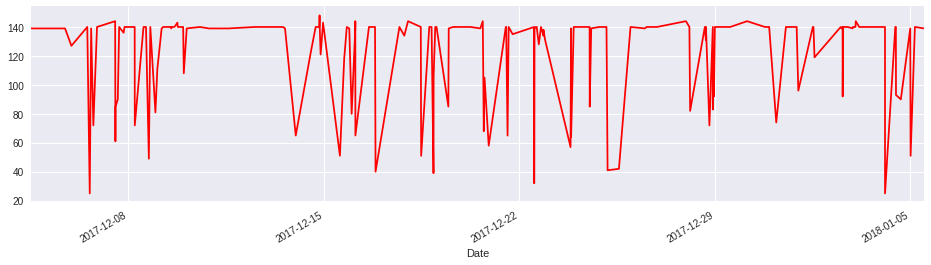

In [8]:
# We create time series for data:

tlen = pd.Series(data=data['len'].values, index=data['Date'])
tfav = pd.Series(data=data['Likes'].values, index=data['Date'])
tret = pd.Series(data=data['RTs'].values, index=data['Date'])

# Lenghts along time:
tlen.plot(figsize=(16,4), color='r');

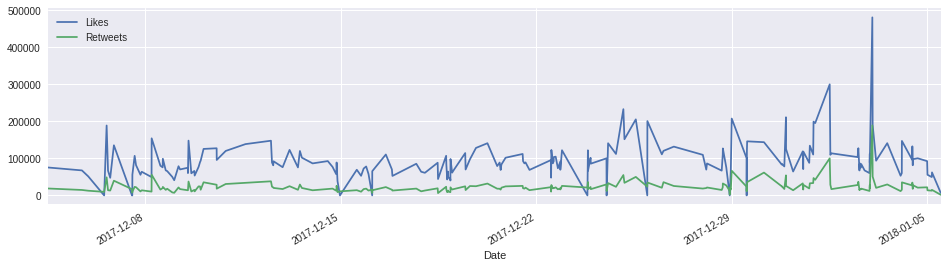

In [9]:
# Likes vs retweets visualization:
tfav.plot(figsize=(16,4), label="Likes", legend=True)
tret.plot(figsize=(16,4), label="Retweets", legend=True);

In [10]:
# We obtain all possible sources:
sources = []
for source in data['Source']:
    if source not in sources:
        sources.append(source)

# We print sources list:
print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

Creation of content sources:
* Twitter for iPhone
* Twitter Web Client
* Media Studio
* Twitter for iPad


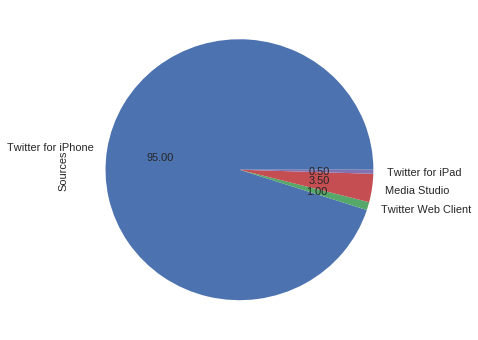

In [11]:
# We create a numpy vector mapped to labels:
percent = np.zeros(len(sources))

for source in data['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100

# Pie chart:
pie_chart = pd.Series(percent, index=sources, name='Sources')
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(6, 6));

## Sentiment Analysis


In [14]:
from textblob import TextBlob
import re

def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [15]:
# We create a column with the result of the analysis:
data['SA'] = np.array([ analize_sentiment(tweet) for tweet in data['Tweets'] ])

# We display the updated dataframe with the new column:
display(data.head(10))

,Tweets,len,ID,Date,Source,Likes,RTs,SA
0,"Dow goes from 18,589 on November 9, 2016, to 2...",139,949242950659313669,2018-01-05 11:35:30,Twitter for iPhone,6673,1694,1
1,The Fake News Media barely mentions the fact t...,140,949129410208202757,2018-01-05 04:04:20,Twitter for iPhone,62235,15020,-1
2,I authorized Zero access to White House (actua...,140,949126530839572481,2018-01-05 03:52:53,Twitter for iPhone,49614,12885,1
3,MAKING AMERICA GREAT AGAIN! https://t.co/iONbr...,51,949070800417640454,2018-01-05 00:11:26,Twitter for iPhone,55896,13786,1
4,Thank you to the great Republican Senators who...,139,949066181381632001,2018-01-04 23:53:05,Twitter for iPhone,92646,21965,1
5,"Dow just crashes through 25,000. Congrats! Big...",90,948944124132167680,2018-01-04 15:48:04,Twitter for iPhone,100431,21030,-1
6,So beautiful....Show this picture to the NFL p...,93,948881133340708864,2018-01-04 11:37:46,Twitter for iPhone,97882,27612,1
7,"With all of the failed “experts” weighing in, ...",140,948879774277128197,2018-01-04 11:32:22,Twitter for iPhone,81597,17854,-1
8,"As Americans, you need identification, sometim...",140,948874586006925313,2018-01-04 11:11:45,Twitter for iPhone,132629,34718,1
9,Many mostly Democrat States refused to hand ov...,140,948872192284155904,2018-01-04 11:02:14,Twitter for iPhone,96384,27106,1


In [16]:
# We construct lists with classified tweets:

pos_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] < 0]

# We print percentages:

print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(data['Tweets'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(data['Tweets'])))
print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(data['Tweets'])))

Percentage of positive tweets: 56.0%
Percentage of neutral tweets: 22.5%
Percentage de negative tweets: 21.5%
